# Planification de la trajectoire d'un objet mobile à partir des images video
### BRIKCI Mohammed El Hadi et BRAHIM Riadh

Dans ce code on une solution detection des lignes de la voie . En suivant les etapes suivante:

1. Camera Calibration   
2. Distortion Correction   
3. Seuillage de Gradient (Canny) et Seuillage de couleur 
4. Perspective Transform   
5. Lane Line Search & Search Optimization
6. Drawing the lane overlay


##### Bibliothèques requises

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import io
import os
import glob
%matplotlib inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## ---
## 1. Calculer l'étalonnage de la caméra à l'aide d'images d'échiquier

In [3]:
images = glob.glob('camera_cal/calibration*.jpg') #glob pour charger +ieurs images

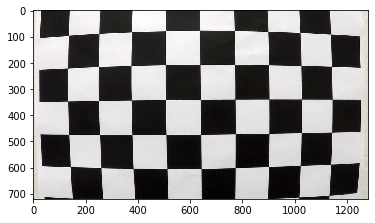

In [4]:
img = mpimg.imread(images[0]) #Liire la 1er image
plt.imshow(img);

In [5]:
# stocker les coordonnées de l'échiquier
chess_points = []
# stocker les points img transformés
image_points = []

In [6]:
# Plache de 6 Lignes et 9 columnes. chaque élément est un (xyz) point 
# Rappel, on s'interesse que des points intérieurs. c'est pour sa la plache est de  9x6, au lieu 10x7
chess_point = np.zeros((9*6, 3), np.float32)
# z reste zero. définir xy au valeurs de la grille
chess_point[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [7]:
for image in images:
    
    img = mpimg.imread(image)
    # convertir au niveau de gris
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    # returner booléen s/e et les coordonnes
    success, corners = cv.findChessboardCorners(gray, (9,6), None)
    
    if success:
        image_points.append(corners)
        #Ils seront tous les mêmes puisque c'est la même planche
        chess_points.append(chess_point)
    else:
        print('corners not found {}'.format(image))
        

corners not found camera_cal\calibration1.jpg
corners not found camera_cal\calibration4.jpg
corners not found camera_cal\calibration5.jpg


<Figure size 432x288 with 0 Axes>

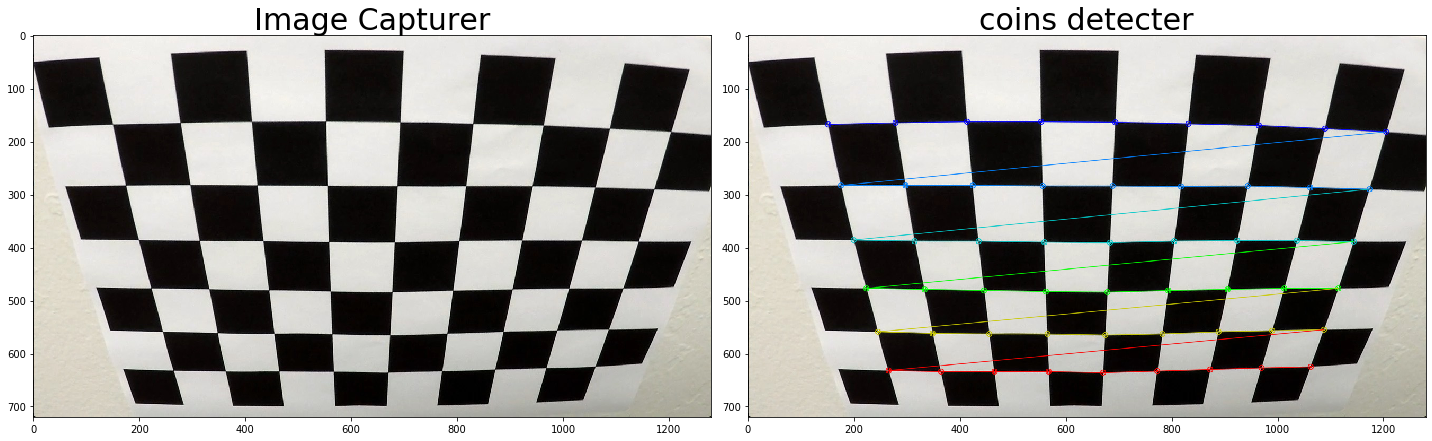

In [8]:
image = mpimg.imread('./camera_cal/calibration2.jpg')

plt.figure();
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(image);
ax1.set_title('Image Capturer', fontsize=30);

gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY) 
ret , corners = cv.findChessboardCorners(gray,(9,6),None)    
if ret == False:
    print('coins no detecter')
img1 = cv.drawChessboardCorners(image,(9,6),corners,ret) 

ax2.imshow(img1);
ax2.set_title('coins detecter', fontsize=30);
plt.tight_layout();
plt.savefig('saved_figures/chess_corners.png');
plt.show;

In [9]:
# Sauvegarder les donnees dans un fichier! est en comentaire pcq c'st pas la peine de sauvegarder a chaque fois
# points_pkl = {}
# points_pkl["chesspoints"] = chess_points
# points_pkl["imagepoints"] = image_points
# points_pkl["imagesize"] = (img.shape[1], img.shape[0])
# pickle.dump(points_pkl,open("object_and_image_points.pkl", "wb" ))

In [10]:
points_pickle = pickle.load( open( "object_and_image_points.pkl", "rb" ) )
chess_points = points_pickle["chesspoints"]
image_points = points_pickle["imagepoints"]
img_size = points_pickle["imagesize"]

In [11]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(chess_points, image_points, img_size, None, None)

In [12]:
# enregistrer dans un fichier pickle!
# camera = {}
# camera["mtx"] = mtx
# camera["dist"] = dist
# camera["imagesize"] = img_size
# pickle.dump(camera, open("camera_matrix.pkl", "wb"))

In [13]:
def distort_correct(img,mtx,dist,camera_img_size):
    img_size1 = (img.shape[1],img.shape[0])
    #print(img_size1)
    #print(camera_img_size)
    assert (img_size1 == camera_img_size),'image size is not compatible'
    undist = cv.undistort(img, mtx, dist, None, mtx)
    return undist

<Figure size 432x288 with 0 Axes>

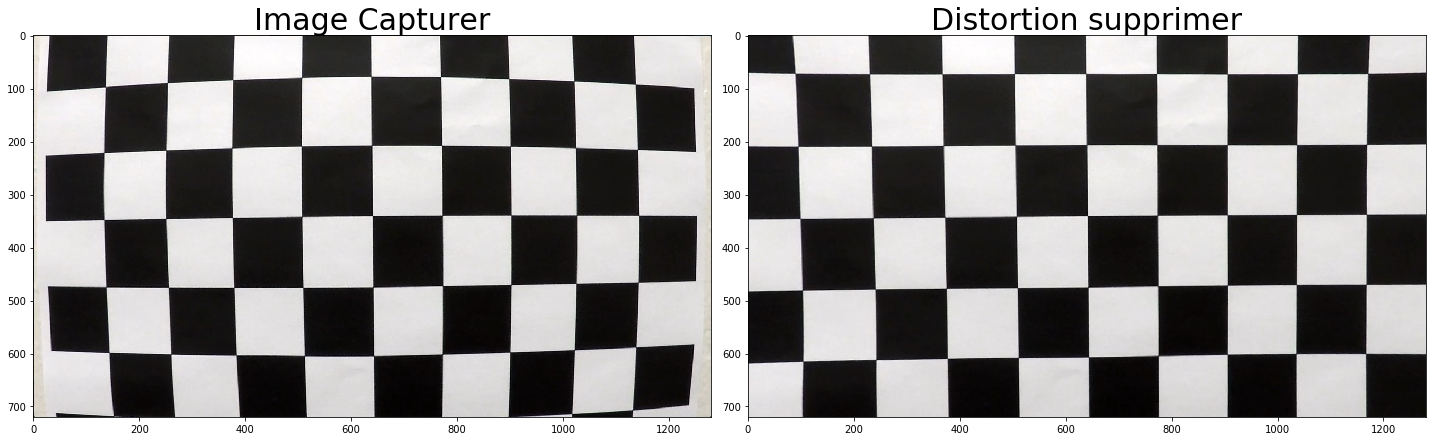

In [14]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
img_size1 = (img.shape[1], img.shape[0])

undist = distort_correct(img, mtx, dist, img_size)

### Visualize the captured 
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Image Capturer', fontsize=30);
ax2.imshow(undist);
ax2.set_title('Distortion supprimer', fontsize=30);
plt.tight_layout()
plt.savefig('saved_figures/undistorted_chess.png')

### seillage de gradient et couleur

Pour ce projet, nous utiliserons plusieurs filtres pour générer une image binaire (noir et blanc) avec laquelle nous pouvons détecter  les lignes de voie.

* Sobel gradients en x & y directions
* Gradient magnitude
* Gradient direction
* Transformation et filtrage de l'espace colorimétrique

In [15]:
########################################################""
# charger camera matrix et distortion matrix
camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
mtx = camera['mtx']
dist = camera['dist']
camera_img_size = camera['imagesize']

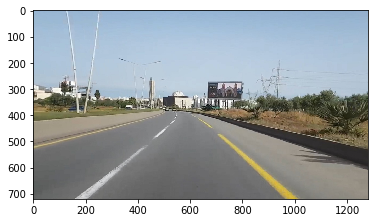

In [16]:
# obtenir un cadre undistorted dashcam 
image = mpimg.imread('test_images/barki.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)
plt.imshow(image);

#### Sobel gradients
Canny Edge Detection (detecteur de contour) combine le gradient sobel pour x et y. En le décomposant en ses composants, 
on peut produire une version raffinée de la détection des contours Canny.

In [17]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convertir en niveau de gris
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Appliquer x ou y gradient avec la fonction OpenCV Sobel() 
    # et prendre la valeur absolue
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1))
    # Reduire a entier de 8 bit 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Creer une copie et appliquer le suillage
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Returner le resultat
    return binary_output

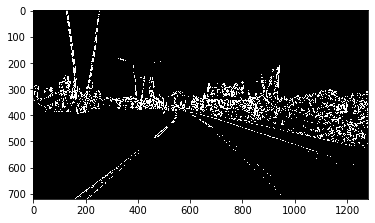

In [18]:
# modifier la couleur de map en gris, RGB par defaut
plt.imshow(abs_sobel_thresh(image, thresh=(20,110)),  cmap='gray');

#### Gradient Magnitude
La fonction ci-dessous filtrera en fonction d'une magnitude min / max pour le gradient. Cette fonction examine le gradient xy combiné, mais il pourrait être modifié pour filtrer la magnitude dans une seule direction, ou une combinaison linéaire des deux.

In [19]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the xy magnitude 
    mag = np.sqrt(x**2 + y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale = np.max(mag)/255
    eightbit = (mag/scale).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(eightbit)
    binary_output[(eightbit > thresh[0]) & (eightbit < thresh[1])] =1 
    return binary_output

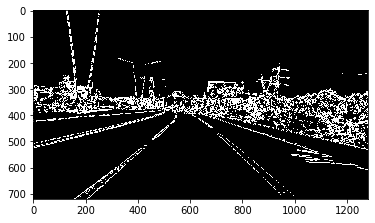

In [20]:
plt.imshow(mag_threshold(image, thresh=(20,100)),  cmap='gray');

#### Gradient Direction
Cette fonction filtrera en fonction de la direction du gradient. Pour la détection de voie, on sera intéressés par les lignes verticales qui sont +/- un certain seuil près $\frac{\pi}{2}$

In [21]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel))
    y = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(y, x)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

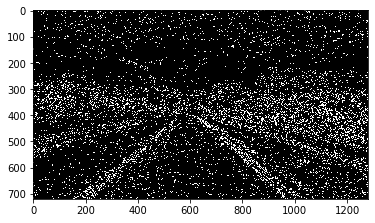

In [22]:
plt.imshow(dir_threshold(image, thresh=(0.8,1.2)),  cmap='gray');

#### Saturation Channel & Red Channel Filters
Les filtres de dégradé convertissent avant tout l'image d'origine en niveaux de gris et beaucoup d'informations utiles sont perdues. Les lignes de voie sont jaunes ou blanches, et nous pouvons utiliser cela à notre avantage en essayant de les localiser et de les suivre. The **H**ue **S**aturation **L**ightness (teinte,saturation,légèreté)coleur de espace va nous aider. en particulier, le canal S of an HSL l'image conserve beaucoup d'informations sur les lignes de voie - surtout quand il y a des ombres sur la route. canal rouge de RGB lui aussi fait un bon travaille pour la creation d'image binaire de detection de voie

In [23]:
def hls_select(img, sthresh=(0, 255),lthresh=()):
    # 1) Convert to HLS color space
    hls_img = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S >= sthresh[0]) & (S <= sthresh[1])
                 & (L > lthresh[0]) & (L <= lthresh[1])] = 1
    return binary_output

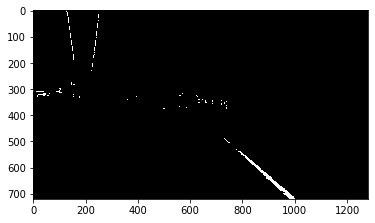

In [24]:
plt.imshow(hls_select(image, sthresh=(140,255), lthresh=(120, 255)),  cmap='gray');

In [25]:
def red_select(img, thresh=(0, 255)):
    # Apply a threshold to the R channel
    R = img[:,:,0]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_output

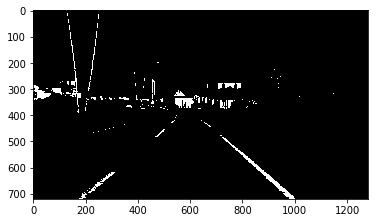

In [26]:
plt.imshow(red_select(image, thresh=(200,255)),  cmap='gray');

### Methodes pour combiner les filtres
Nous pouvons maintenant mélanger et assortir différentes méthodes de filtrage, chacun avec des valeurs de seuil uniques, pour obtenir une image binaire raffinée.

In [27]:
def binary_pipeline(img):
    
    img_copy = cv.GaussianBlur(img, (3, 3), 0)
    #img_copy = np.copy(img)
    
    # color channels
    s_binary = hls_select(img_copy, sthresh=(140, 255), lthresh=(120, 255))
    red_binary = red_select(img_copy, thresh=(200,255))
    
    # Sobel x
    x_binary = abs_sobel_thresh(img_copy,thresh=(25, 200))
    y_binary = abs_sobel_thresh(img_copy,thresh=(25, 200), orient='y')
    xy = cv.bitwise_and(x_binary, y_binary)
    
    #magnitude & direction
    mag_binary = mag_threshold(img_copy, sobel_kernel=3, thresh=(30,100))
    dir_binary = dir_threshold(img_copy, sobel_kernel=3, thresh=(0.8, 1.2))
    
    # Stack each channel
    gradient = np.zeros_like(s_binary)
    gradient[((x_binary == 1) & (y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    S_r = cv.bitwise_or(s_binary, red_binary)
    final_binary = cv.bitwise_or(S_r, gradient)
    
    return final_binary

### Combinateur des Filtres

<Figure size 432x288 with 0 Axes>

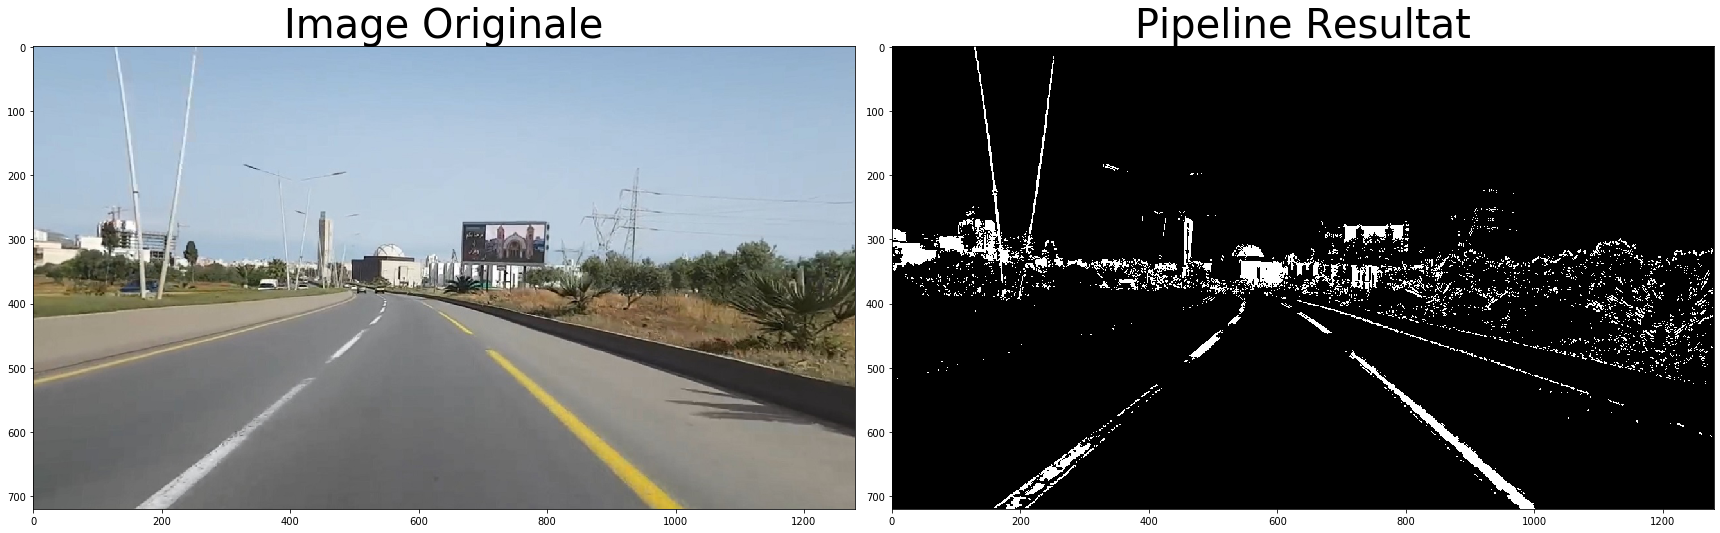

In [28]:
result = binary_pipeline(image)

# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Image Originale', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Resultat', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/combined_filters.png')

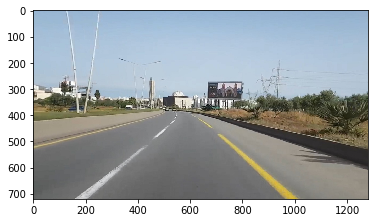

In [29]:
# get an undistorted dashcam frame
image = mpimg.imread('test_images/barki.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)
plt.imshow(image);

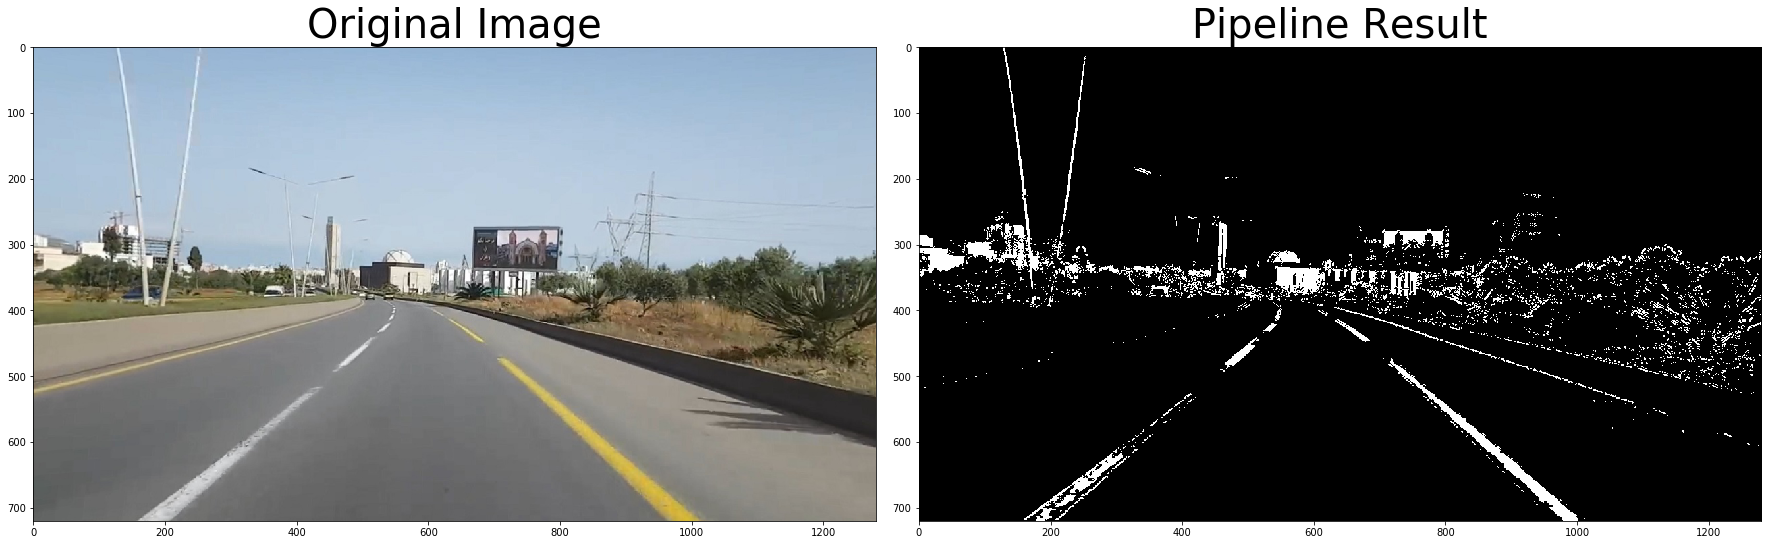

In [30]:
result = binary_pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective transform

In [31]:
def warp_image(img):
    
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    #the "order" of points in the polygon you are defining does not matter
    #but they need to match the corresponding points in destination_points!
    source_points = np.float32([
    [0.117 * x, y],
    [(0.5 * x) - (x*0.13), (2/3)*y],
    [(0.5 * x) + (x*0.078), (2/3)*y],
    [x - (0.117 * x), y]
    ])


    
    destination_points = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])
    
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)
    
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
    
    #print(source_points)
    #print(destination_points)
    
    return warped_img, inverse_perspective_transform

In [32]:
birdseye_result, inverse_perspective_transform = warp_image(image)  # image  #result

# Tracer le resultat
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image.shape[1], image.shape[0])
x = image.shape[1]
y = image.shape[0]
source_points = np.int32([
                    [0.117 * x, y],
                    [(0.5 * x) - (x*0.13), (2/3)*y],
                    [(0.5 * x) + (x*0.078), (2/3)*y],
                    [x - (0.117 * x), y]
                    ])

draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/perspective_transform.png')

<Figure size 432x288 with 0 Axes>

In [33]:
plt.imshow(draw_poly)

<Figure size 432x288 with 0 Axes>

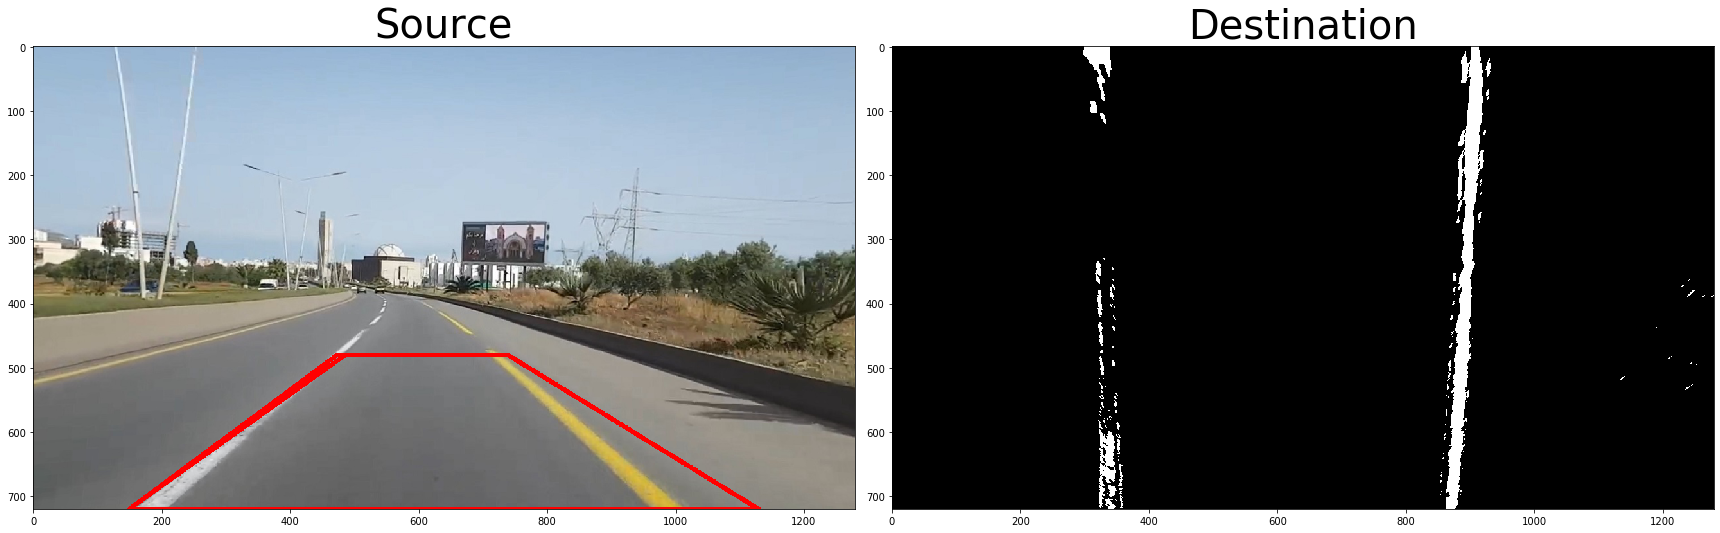

In [34]:
birdseye_result, inverse_perspective_transform = warp_image(result)  # image  #result

# Tracer le resultat
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image.shape[1], image.shape[0])
x = image.shape[1]
y = image.shape[0]
source_points = np.int32([
                    [0.117 * x, y],
                    [(0.5 * x) - (x*0.12), (2/3)*y],
                    [(0.5 * x) + (x*0.078), (2/3)*y],
                    [x - (0.117 * x), y]
                    ])

draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/perspective_transform.png')

In [35]:
# reload the image for later use
image = mpimg.imread('test_images/barki.jpg')
image = distort_correct(image,mtx,dist,camera_img_size)

### Détection les lignes de la voie

Maintenant que notre capture de la route a été transformé, nous sommes prêts à trouver et à suivre les voies réelles. Pour ce faire, nous pouvons identifier les zones avec un nombre élevé de pixels blancs. Plus précisément, nous utiliserons un histogramme pour regrouper les pixels en colonnes et rechercher des pics dans la distribution.

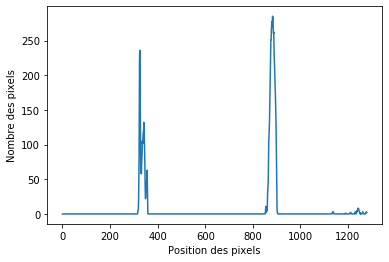

In [36]:
#regardez seulement la moitié inférieure de l'image
histogram = np.sum(birdseye_result[int(birdseye_result.shape[0]/2):,:], axis=0)
plt.figure();
plt.plot(histogram);
plt.xlabel('Position des pixels')
plt.ylabel('Nombre des pixels')
plt.savefig('saved_figures/lane_histogram.png')

Nous pouvons clairement voir où se trouvent les voies dans cet histogramme. En mettant en place une fenêtre coulissante, nous pouvons suivre les pics lorsqu'ils virent à gauche / droite en raison de la légère courbure de la route.

La fonction ci-dessous fonctionne comme suit:
1. Créez une fenêtre de recherche en bas de l'image dont la hauteur est $\frac{1}{9}$ de la hauteur de l'image. 
2. Divisez la fenêtre en deux parties gauche et droite.
3. Localisez la colonne de pixels avec la valeur la plus élevée dans l'histogramme.
4. Tracez un cadre autour de cette zone à l'aide d'une variable de marge. 
5. Identifiez tous les pixels non nuls de cette zone. S'il y en a assez, centrez la boîte sur leur position moyenne pour la fenêtre suivante.
6. Ajuster une équation quadradtique à tous les pixels non nuls identifiés dans chaque moitié de l'image (voie de gauche et voie de droite)

In [37]:
def track_lanes_initialize(binary_warped):
    
    global window_search
    
    # x = img.shape[1]
    # y = img.shape[0]
    # Prenez un histogramme de la moitié inférieure de l'image
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Créez une image de sortie pour dessiner et visualiser le résultat
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # nous avons besoin de max pour chaque moitié de l'histogramme. l'exemple ci-dessus montre comment
    # les choses pourraient être compliquées si elles ne divisaient pas l'image en deux
    # avant de prendre les 2 premiers maxs
    #  [[0 6 2 3 4] 
    #   [5 6 7 8 9]]
    # tableau: 9      INDICES MAX ÉLÉMENT: [1 0 1 1 1]
    
    midpoint = np.int(histogram.shape[0]/2) # le melieu de axe y
    leftx_base = np.argmax(histogram[:midpoint])   # les indices de Max de la 1er moitie
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint   # les indices de Max de la 2eme moitie
    
    # Choisissez le nombre de fenêtres coulissantes
    # cela générera une erreur de hauteur si elle ne divise pas également la hauteur img
    nwindows = 9
    # Définir la hauteur des fenêtres
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identifier les positions x et y de tous les pixels non nuls de l'image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Positions actuelles à mettre à jour pour chaque fenêtre
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Définir la largeur des fenêtres +/- marge
    margin = 100
    # Définir le nombre minimum de pixels trouvés dans la fenêtre la plus récente
    minpix = 50
    # Créez des listes vides pour recevoir les indices de pixels des voies gauche et droite
    left_lane_inds = []
    right_lane_inds = []
    
    
    # Parcourez les fenêtres une par une
    for window in range(nwindows):
        # Identifier les limites des fenêtres en x et y (et à droite et à gauche)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Dessinez les fenêtres sur l'image de visualisation
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identifiez les pixels non nuls en x et y dans la fenêtre
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Ajouter ces indices aux listes
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # Si vous avez trouvé> pixels minpix, plus récente fenêtre suivante sur leur position moyenne
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
    # Concaténer les tableaux d'indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extraire les positions des pixels des lignes gauche et droite
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Adapter un polynôme de second ordre à chacun
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Générer des valeurs x et y pour le traçage
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Encore une fois, extraire les positions des pixels des lignes gauche et droite
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Adapter un polynôme de second ordre à chacun
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

In [38]:
left_fit,right_fit = track_lanes_initialize(birdseye_result)

In [39]:
Image('saved_figures/01_window_search.png')

In [40]:
def track_lanes_update(binary_warped, left_fit,right_fit):

    global window_search
    global frame_count
    
    # repeat window search to maintain stability
    if frame_count % 10 == 0:
        window_search=True
   
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    return left_fit,right_fit,leftx,lefty,rightx,righty

In [41]:
global frame_count
frame_count=0
left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye_result, left_fit,right_fit)

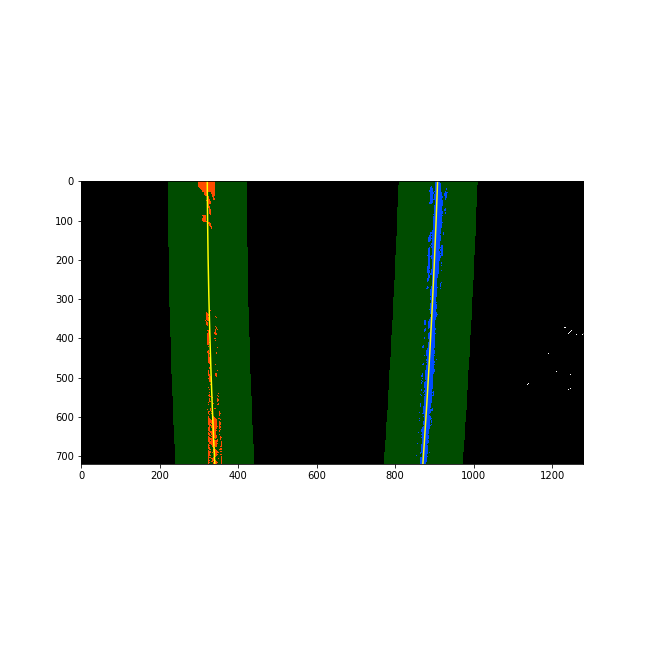

In [42]:
Image('saved_figures/02_updated_search_window.png')

In [43]:
# A function to get quadratic polynomial output
def get_val(y,poly_coeff):
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

In [44]:
def lane_fill_poly(binary_warped,undist,left_fit,right_fit):
    
    # Generer les valeurs de x et y
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane 
    cv.fillPoly(color_warp, np.int_([pts]), (0,200,255))

    # Warp using inverse perspective transform
    newwarp = cv.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0])) 
    # overlay
    #newwarp = cv.cvtColor(newwarp, cv.COLOR_BGR2RGB)
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    return result

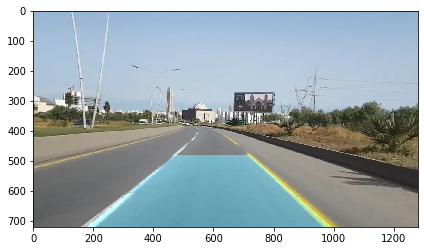

In [45]:
colored_lane = lane_fill_poly(birdseye_result, image, left_fit, right_fit)
plt.figure()
plt.imshow(colored_lane);
plt.tight_layout()
plt.savefig('saved_figures/lane_polygon.png')

In [46]:
def measure_curve(binary_warped,left_fit,right_fit):
        
    # génirer des valures de y  
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # mesurer le rayon de la valeur maximale de y , ou en bas de l'image
    # la plus proche de la voiture 
    y_eval = np.max(ploty)
    
    # coversion  le taux des pixels en métres
    # ce taux peut changer la resolution de la camera !!!!!
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # x positions des voies
    leftx = get_val(ploty,left_fit)
    rightx = get_val(ploty,right_fit)

    # fit polynomials en métres 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # calculate radii in metric from radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # averaged radius of curvature of left and right in real world space
    # should represent approximately the center of the road
    curve_rad = round((left_curverad + right_curverad)/2)
    
    return curve_rad

In [47]:
def vehicle_offset(img,left_fit,right_fit):
    
   
    xm_per_pix = 3.7/700 
    image_center = img.shape[1]/2
    
    ## Trouver les lignes proche de la voiture
    left_low = get_val(img.shape[0],left_fit)
    right_low = get_val(img.shape[0],right_fit)
    
    # pixel coordinate for center of lane
    lane_center = (left_low+right_low)/2.0
    
    ## vehicle offset
    distance = image_center - lane_center
    
    ## convert to metric
    return (round(distance*xm_per_pix,5))

In [48]:
offset = vehicle_offset(colored_lane, left_fit, right_fit)
print(offset)

0.18143


In [49]:
def img_pipeline(img):
    
    global window_search
    global left_fit_prev
    global right_fit_prev
    global frame_count
    global curve_radius
    global offset
        
    # load camera matrix and distortion matrix
    camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
    mtx = camera['mtx']
    dist = camera['dist']
    camera_img_size = camera['imagesize']
    
    #correct lens distortion
    undist = distort_correct(img,mtx,dist,camera_img_size)
    # get binary image
    binary_img = binary_pipeline(undist)
    #perspective transform
    birdseye, inverse_perspective_transform = warp_image(binary_img)
    
    if window_search:
        #window_search = False
        #window search
        left_fit,right_fit = track_lanes_initialize(birdseye)
        #store values
        left_fit_prev = left_fit
        right_fit_prev = right_fit
        
    else:
        #load values
        left_fit = left_fit_prev
        right_fit = right_fit_prev
        #search in margin of polynomials
        left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye, left_fit,right_fit)
    
    #save values
    left_fit_prev = left_fit
    right_fit_prev = right_fit
    
    #draw polygon
    processed_frame = lane_fill_poly(birdseye, undist, left_fit, right_fit)
    
    #update ~twice per second
    if frame_count==0 or frame_count%15==0:
        #measure radii
        curve_radius = measure_curve(birdseye,left_fit,right_fit)
        #measure offset
        offset = vehicle_offset(undist, left_fit, right_fit)
    
        
    #printing information to frame
    font = cv.FONT_HERSHEY_TRIPLEX
    processed_frame = cv.putText(processed_frame, 'Rayon: '+str(curve_radius)+' m', (500, 620), font, 1, (0,0,0), 2)
    processed_frame = cv.putText(processed_frame, 'Decalage: '+str(offset)+' m', (500, 660), font, 1, (0,0,0), 2)
   
    frame_count += 1
    return processed_frame

In [50]:
filenames = os.listdir("test_images/")
global window_search
global frame_count
for filename in filenames:
    frame_count = 15
    window_search = True
    image = mpimg.imread('test_images/'+filename)
    lane_image = img_pipeline(image)
    mpimg.imsave('output_images/lane_'+filename,lane_image)

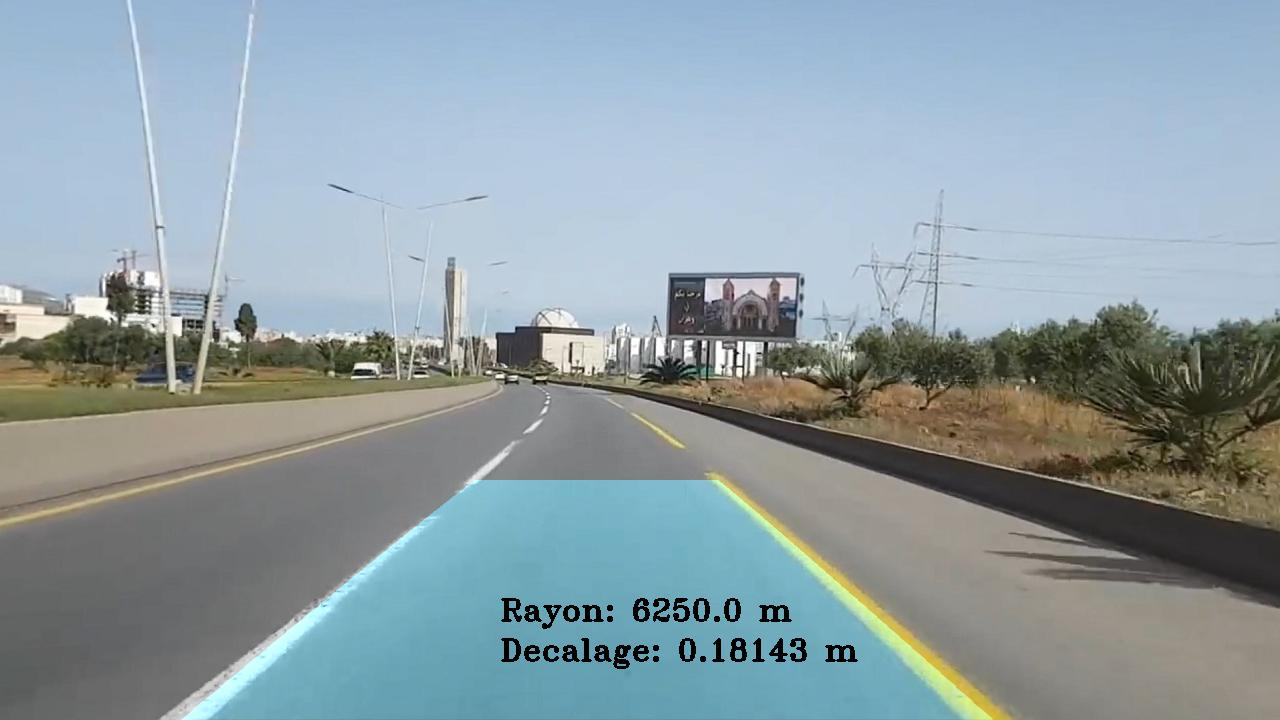

In [51]:
Image('output_images/lane_barki.jpg')

# Video Processing

In [52]:
from moviepy.video.fx.all import crop

In [53]:
global window_search 
global frame_count
window_search = True
frame_count = 0

for filename in ['highway45 내서 창녕_Trim.mp4']:
    clip = VideoFileClip('videos/'+filename)#.subclip((3,25),(3,35))
    #clip_crop = crop(clip, x1=320, y1=0, x2=1600, y2=720)
    out= clip.fl_image(img_pipeline)
    #out = clip_crop.fl_image(img_pipeline)
    out.write_videofile('output_videos/processed_'+filename, audio=False, verbose=False)
    print('Success!')

Moviepy - Building video output_videos/processed_highway45 내서 창녕_Trim.mp4.
Moviepy - Writing video output_videos/processed_highway45 내서 창녕_Trim.mp4



t:  21%|█████████████▉                                                    | 381/1797 [02:42<08:38,  2.73it/s, now=None]

TypeError: expected non-empty vector for x

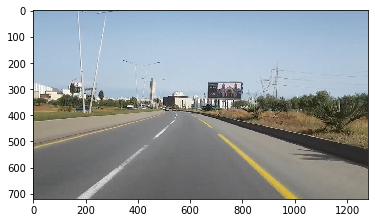

In [87]:
# get an undistorted dashcam frame
image = mpimg.imread('test_images/barki.jpg')
plt.imshow(image);

In [1]:
gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
plt.imshow(gray,  cmap='gray');

NameError: name 'cv' is not defined

In [ ]:
camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
camera